## Step one: load map image

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from yaml import load, dump
import skimage
import os

MAPS_DIR = 'maps'

map_name = 'tor_testowy_02'
with open(os.path.join(MAPS_DIR, map_name+'.yaml'), 'r') as f:
    map_meta = load(f)

print(map_meta)
map_img = mpimg.imread(os.path.join(MAPS_DIR, map_meta['image']))
print(map_img.shape)

if map_meta['negate']:
    p = map_img / 255.0
else:
    p = (255 - map_img) / 255.0

plt.imshow(p, cmap='gray')
plt.show()

{'image': 'tor_testowy_02.pgm', 'resolution': 0.05, 'origin': [-51.224998, -51.224998, 0.0], 'negate': 0, 'occupied_thresh': 0.65, 'free_thresh': 0.196}
(2048, 2048)


<Figure size 640x480 with 1 Axes>

## Step two: identify occupied and free cells

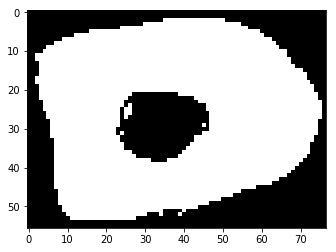

In [2]:
import numpy as np

occupied = np.zeros_like(map_img)
free     = np.zeros_like(map_img)

occupied[p > map_meta['occupied_thresh']] = 1.0
free[p < map_meta['free_thresh']] = 1.0

B = np.argwhere(occupied | free)
(ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1

free_trim = free[ystart:ystop, xstart:xstop]

plt.imshow(free_trim, cmap='gray')
plt.show()

## Step three: identify center line

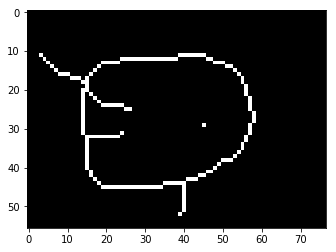

In [3]:
from skimage.morphology import binary_erosion, skeletonize, thin

skeleton = skeletonize(free_trim)

plt.imshow(skeleton, cmap='gray')
plt.show()

## Step four: extract pixels belonging to the closed circuit

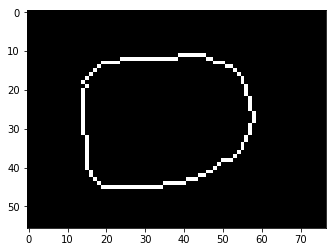

In [4]:
from itertools import permutations

OFFSETS = [-1, 0, 1]
NEIGHBORHOOD = [(dy, dx) for dx in OFFSETS for dy in OFFSETS]

available = np.copy(skeleton).astype(np.bool)

def dfs(point, target, available, path, remaining_steps=15):
    x = point[0]
    y = point[1]
    
    if (remaining_steps == 0) and (point == target).all(): return True
    if not available[y, x]: return False
    
    remaining_steps = max(0, remaining_steps-1)
    
    available[y, x] = False
    path.append(point)
    
    for dx, dy in NEIGHBORHOOD:
        child_x = x + dx
        child_y = y + dy
        
        if dfs((child_x, child_y), target, available, path, remaining_steps):
            return True

    path.pop()
    return False

starting_points = np.transpose(np.nonzero(available))
for starting_point in starting_points:
    path = []
    
    if dfs(starting_point, starting_point, available, path):
        break

path_img = np.zeros_like(skeleton)
for point in path:
    path_img[point[1], point[0]] = 1

plt.imshow(path_img, cmap='gray')
plt.show()

## Step five: calculate offset from lane center 

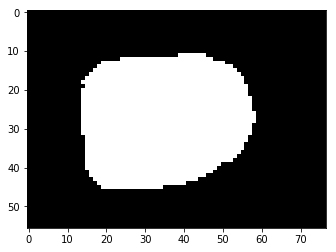

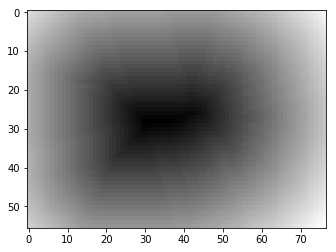

In [5]:
from scipy.ndimage.morphology import binary_fill_holes

interior = np.array(binary_fill_holes(path_img))

plt.imshow(interior, 'gray')
plt.show()

def calc_offset(y, x):
    point = (x, y)
    
    closest_point_idx = np.argmin(np.sum(np.square(np.array(point) - path), 1))
    closest_point = path[closest_point_idx]
    
    dist = np.sqrt((x-closest_point[0])**2 + (y-closest_point[1])**2)
    
    if interior[int(y), int(x)]:
        return -dist
    else:
        return dist

calc_offsets = np.vectorize(calc_offset)

offsets = np.fromfunction(calc_offsets, interior.shape) * map_meta['resolution']

plt.imshow(offsets, cmap='gray')
plt.show()

## Step six: Save results to file

In [6]:
import pickle

data = {}

res = map_meta['resolution']

data['resolution'] = res
data['origin'] = [
    map_meta['origin'][0] + xstart * res,
    map_meta['origin'][1] + (map_img.shape[0] - ystop - 1) * res
]

data['offsets'] = offsets

with open(map_name+'.pkl', 'wb') as f:
    pickle.dump(data, f, 2)